<a href="https://colab.research.google.com/github/zisserj/monty_inference/blob/master/monty_BN_and_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pomegranate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.7 MB/s eta 0:00:00


In [2]:
from pomegranate import distributions
from pomegranate.bayesian_network import BayesianNetwork
import torch
import numpy as np
import time

In [30]:
doorsNums = [i for i in range(10, 500, 20)]

In [4]:

# following https://github.com/jmschrei/pomegranate/blob/f0b966e8fb0d6cf27b0d83a6f826d739751d91d4/examples/Bayesian_Network_Monty_Hall.ipynb

def time_monty_net(num_doors, return_model=False):
    time_start = time.perf_counter_ns()

    # doors = [f'd{i}' for i in range(1, num_doors+1)] # names, not really needed anymore
    door_rate = 1./num_doors
    uniform_dist = np.ones([1, num_doors]) * door_rate

    guest = distributions.Categorical(uniform_dist)
    prize = distributions.Categorical(uniform_dist)

    # generate transition matrix
    probs_matrix = np.ones((1, num_doors, num_doors, num_doors)) * (1/(num_doors-2))

    for g in range(num_doors):
        # [0,table,row,column]
        np.fill_diagonal(probs_matrix[0,g], 0)
        probs_matrix[0,g,g,:] = 1/(num_doors-1)
        probs_matrix[0,g,:,g] = 0

    monty = distributions.ConditionalCategorical(probs_matrix)

    model = BayesianNetwork([guest, prize, monty], [(guest, monty), (prize, monty)])
    if return_model:
        return model
    return time.perf_counter_ns() - time_start 

In [8]:
rate = [time_monty_net(n)/n for n in doorsNums]
rate # time per foor in ns

[915108.9,
 132947.33333333334,
 132805.36,
 198341.8142857143,
 320722.6111111111,
 444161.91818181815,
 741525.176923077,
 1013684.68,
 1300417.5294117648,
 1633630.0736842104,
 1978809.019047619,
 2323148.4434782607,
 2718441.984,
 4117781.437037037,
 4822690.017241379,
 4201982.264516129,
 4890045.2,
 5484488.885714286,
 6114556.127027027,
 7079342.682051282,
 9869016.39512195,
 8257427.539534884,
 8844333.966666667,
 10631889.731914893,
 10378402.930612246]

In [15]:
import matplotlib.pyplot as plt

In [16]:
rate_bn = rate
rate_mcmc = [
15096377.9,  4637944.033333333,
          2499961.46,          2048550.9,
  1910711.8666666667,  1860929.490909091,
  1727240.8846153845, 1726806.7333333334,
  1746743.9764705882,  1635721.652631579,
  1643661.3142857142, 1627464.8347826088,
         1546842.284, 1633105.0333333334,
  1576822.8862068965, 1582971.2193548386,
  1598141.0454545454, 1613627.5685714285,
  1555245.9513513513,  1608377.717948718,
  1628475.5195121951, 1554221.8488372094,
  1523117.9466666668, 1574526.9829787235,
  1601492.2285714287]

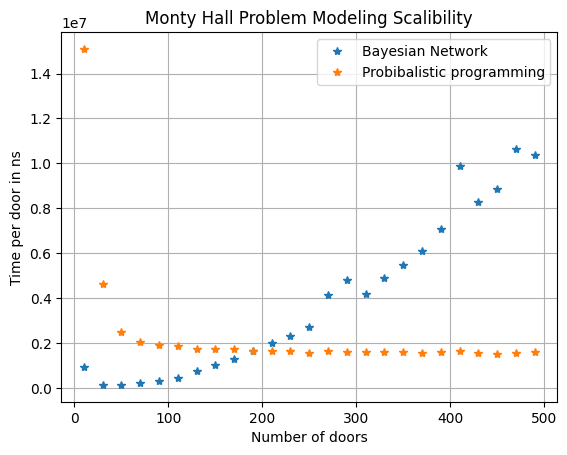

In [31]:
plt.plot(doorsNums, rate_bn, '*', label='Bayesian Network')
plt.plot(doorsNums, rate_mcmc, '*', label='Probibalistic programming')
plt.title("Monty Hall Problem Modeling Benchmark")
plt.legend()
plt.xlabel("Number of doors")
plt.ylabel("Time per door in ns")
plt.grid()
plt.show()

In [12]:
model = time_monty_net(3, return_model=True)

In [13]:
X1 = torch.tensor([[2, 1, -1]])

X1_masked = torch.masked.MaskedTensor(X1, mask=X1 >= 0)

model.predict(X1_masked)

/usr/local/lib/python3.10/dist-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


tensor([[2, 1, 0]])

In [ ]:
X2 = torch.tensor([[2, 1, -1]])
X2_masked = torch.masked.MaskedTensor(X2, mask=X2 >= 0)
model.probability(X2_masked)

In [14]:
model.distributions[2].probs[0]

Parameter containing:
tensor([[[0.0000, 0.5000, 0.5000],
         [0.0000, 0.0000, 1.0000],
         [0.0000, 1.0000, 0.0000]],

        [[0.0000, 0.0000, 1.0000],
         [0.5000, 0.0000, 0.5000],
         [1.0000, 0.0000, 0.0000]],

        [[0.0000, 1.0000, 0.0000],
         [1.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000]]], dtype=torch.float64)